In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install transformers==4.5.1 datasets sentencepiece syllables
! python -m spacy download de_core_news_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Promotion/text_complexity/')

## Use Trainer

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, T5Model
import torch
from utils import scatter_preds, metric_eval, rmse_mapped

In [ ]:
#base_model_string = "bert-base-german-cased"
base_model_string = "distilbert-base-german-cased"
#base_model_string = "deepset/gbert-base"
#"Sahajtomar/German_Zeroshot"
# "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
#"xlm-roberta-large-finetuned-conll03-german"
#"deepset/gbert-large"
# "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(base_model_string)

#tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
import datasets

data = datasets.load_dataset('csv', data_files='/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced.csv')
data = data['train'].rename_columns({'MOS': 'label'})
def tokenize_data(example):
    return tokenizer(example['Sentence'])#, padding=True, return_tensors='pt', truncation=True, max_length=512)

data = data.map(tokenize_data, batched=True)
data = data.train_test_split(test_size=0.05)
data

Using custom data configuration default-8c8681a447d59e96


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8c8681a447d59e96/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Parameter 'function'=<function tokenize_data at 0x7f1085c10710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['index', 'sentence_id', 'Sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1001
    })
    test: Dataset({
        features: ['index', 'sentence_id', 'Sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 53
    })
})

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

base_model = AutoModelForSequenceClassification.from_pretrained(base_model_string, num_labels=1, output_hidden_states=True, return_dict=True)
#base_model.config.pad_token_id = tokenizer.pad_token_id
#base_model.to(device)

cuda:0


Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias

In [ ]:
training_args = TrainingArguments('models/trainer', num_train_epochs=2)

In [ ]:
trainer = Trainer(model=base_model, args=training_args, tokenizer=tokenizer, train_dataset=data['train'], eval_dataset=data['test'], compute_metrics=rmse_mapped)
trainer.train()

Step,Training Loss


TrainOutput(global_step=252, training_loss=0.6510876852368551, metrics={'train_runtime': 57.9044, 'train_samples_per_second': 4.352, 'total_flos': 49233444980070.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 270719488, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 4096, 'train_mem_gpu_alloc_delta': 275210752, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 313247232})

In [ ]:
trainer.evaluate()

{'epoch': 2.0,
 'eval_loss': 0.33411046862602234,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 228496384,
 'eval_rmse_mapped': 0.5646562576293945,
 'eval_runtime': 0.5083,
 'eval_samples_per_second': 104.276}

0.38396269835980995
{'rmse_mapped': 0.3783467520880684}


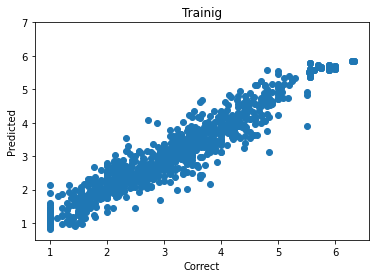

0.5780228232376107
{'rmse_mapped': 0.5646563224671249}


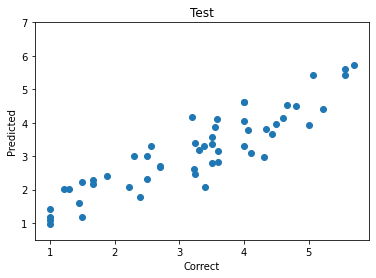

In [ ]:
from transformers import EvalPrediction
import numpy as np

y_pred_train = trainer.predict(test_dataset=data['train'])[0]
y_pred_test = trainer.predict(test_dataset=data['test'])[0]

labels_train = np.array(data['train']['label'])
labels_test = np.array(data['test']['label'])

print(metric_eval(labels_train, y_pred_train[0], classification=False))
print(rmse_mapped(EvalPrediction(predictions=y_pred_train, label_ids=labels_train)))
scatter_preds(labels_train, y_pred_train[0], 'Trainig')
print(metric_eval(labels_test, y_pred_test[0], classification=False))
print(rmse_mapped(EvalPrediction(predictions=y_pred_test, label_ids=labels_test)))
scatter_preds(labels_test, y_pred_test[0], 'Test')

In [ ]:
#torch.save(base_model, '/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_trainer.pt')
trainer.save_model('/content/drive/MyDrive/Promotion/text_complexity/models/test')

In [ ]:
#data_val = datasets.load_dataset('csv', data_files='/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv')
data_val = datasets.load_dataset('csv', data_files='/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/part2_public.csv')
def tokenize_data(example):
    return tokenizer(example['Sentence'])

data_val = data_val.map(tokenize_data, batched=True)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a6c7ce04414bc938/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
preds = trainer.predict(test_dataset=data_val['train'])

In [ ]:
from utils import write_answer_file
import pandas as pd

write_answer_file(data_val['train']['ID'], preds[0][0])

In [ ]:
import pandas as pd
#data_val_df = pd.read_csv('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv')
data_val_df = pd.read_csv('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/part2_public.csv')
answer = pd.DataFrame()
answer['ID'] = data_val_df['ID']
answer['MOS'] = preds[0][0]

answer.to_csv('final_distilbert.csv', index=False)

## SVR with Distilbert features: extract features

In [ ]:
from transformers import DistilBertModel, AutoModel, DistilBertForSequenceClassification

# Sequence Classification for predictions recreation, base model for neural embedding
#pretrained = DistilBertModel.from_pretrained('/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_final')
pretrained = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_final')

In [ ]:
#training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set.csv'
training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced.csv'
target_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv'
final_eval_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/part2_public.csv'
base_model_string = "distilbert-base-german-cased"
seq_max_len = 99

In [ ]:
from transformers import AutoTokenizer

text_cols = 'Sentence'
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'MOS' 
numerical_cols = ['perc_syl_3', 'avg_sent_len', 'perc_word_6', 'perc_syl_1', 
                  'avg_syl_count', 'tree_depth', 'fre_amstad', 'SMOG', 'wstf_1', 
                  'wstf_2', 'wstf_3', 'wstf_4']

tokenizer = AutoTokenizer.from_pretrained(base_model_string)

In [ ]:
from transformers import Trainer, TrainingArguments
feature_trainer = Trainer(model=pretrained, args=TrainingArguments('models/feature_trainer', num_train_epochs=2), tokenizer=tokenizer)

In [ ]:
import torch
from utils import load_data_and_statistics
import numpy as np
class TextComplexityDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, df, numerical_feats, labels_col):
    self.df = df
    self.encodings = encodings
    self.numerical_feats = np.array(df[numerical_feats])
    self.labels = df[labels_col].values if labels_col is not None else torch.zeros(len(df))
  
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    #item['labels'] = torch.tensor(self.labels[idx]) if self.labels is not None  else None
    #item['numerical_feats'] = torch.tensor(self.numerical_feats[idx]).float()\
    #    if self.numerical_feats is not None else torch.zeros(0)
    return item

  def __get_labels__(self):
    return self.labels
  
  def __len__(self):
    return len(self.df)

training_data = load_data_and_statistics(training_data_path)
tok_dat = tokenizer(list(training_data[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)
dat = TextComplexityDataset(tok_dat, training_data, numerical_cols, label_col)
preds = feature_trainer.predict(test_dataset=dat)

In [ ]:
preds[0][0].shape

(1054, 1)

0.40222093664312464
{'rmse_mapped': 0.3993397160005122}


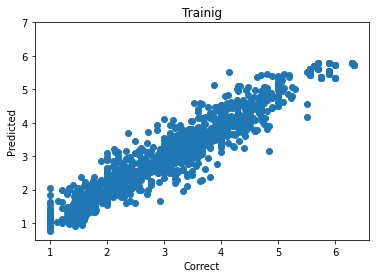

In [ ]:
from transformers import EvalPrediction
import numpy as np
from utils import metric_eval, rmse_mapped, scatter_preds

y_pred_train = preds[0]

labels_train = np.array(dat.__get_labels__())

print(metric_eval(labels_train, y_pred_train[0], classification=False))
print(rmse_mapped(EvalPrediction(predictions=y_pred_train, label_ids=labels_train)))
scatter_preds(labels_train, y_pred_train[0].flatten(), 'Trainig')

In [ ]:
import numpy as np
#np.save('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced_distilbert_final.npy', preds[0][0])np.save('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced_distilbert_final.npy', preds[0][0])
np.load('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced_distilbert_final.npy').shape

(1054, 99, 768)

In [ ]:
data_val_df = load_data_and_statistics(target_data_path)
tok_encoded_val = tokenizer(list(data_val_df[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)

data_val = TextComplexityDataset(tok_encoded_val, data_val_df, numerical_cols, labels_col=None)
preds = feature_trainer.predict(test_dataset=data_val)

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set_distilbert_final.npy', preds[0][0])

In [ ]:
data_val_df = load_data_and_statistics(final_eval_path)
tok_encoded_val = tokenizer(list(data_val_df[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)

data_val = TextComplexityDataset(tok_encoded_val, data_val_df, numerical_cols, labels_col=None)
preds = feature_trainer.predict(test_dataset=data_val)

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/final_set_distilbert_final.npy', preds[0][0])

## Inlcude statistics in Trainer

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, PreTrainedModel, PretrainedConfig
from text_statistics import calculate_statistics
import torch
from utils import metric_eval, scatter_preds, rmse_mapped
import numpy as np

In [ ]:
training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced.csv'
target_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv'
final_eval_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/part2_public.csv'
base_model_string = "distilbert-base-german-cased"

In [ ]:
from utils import load_data_and_statistics

training_data = load_data_and_statistics(training_data_path)

In [ ]:
text_cols = 'Sentence'
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'MOS' 
numerical_cols = ['perc_syl_3', 'avg_sent_len', 'perc_word_6', 'perc_syl_1', 
                  'avg_syl_count', 'tree_depth', 'fre_amstad', 'SMOG', 'wstf_1', 
                  'wstf_2', 'wstf_3', 'wstf_4']

tokenizer = AutoTokenizer.from_pretrained(base_model_string)

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
class TextComplexityDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, df, numerical_feats, labels_col):
    self.df = df
    self.encodings = encodings
    self.numerical_feats = np.array(df[numerical_feats])
    self.labels = df[labels_col].values if labels_col is not None else torch.zeros(len(df))
  
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx]) if self.labels is not None  else None
    item['numerical_feats'] = torch.tensor(self.numerical_feats[idx]).float()\
        if self.numerical_feats is not None else torch.zeros(0)
    return item

  def __get_labels__(self):
    return self.labels
  
  def __len__(self):
    return len(self.df)

data_train_df = training_data.sample(frac=.95)
tok_encoded_train = tokenizer(list(data_train_df[text_cols]), padding=True, truncation=True, return_length=True)
seq_max_len = tok_encoded_train['length'][0]
del tok_encoded_train['length']
data_test_df = training_data.drop(data_train_df.index)
tok_encoded_test = tokenizer(list(data_test_df[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)

data_train = TextComplexityDataset(tok_encoded_train, data_train_df, numerical_cols, label_col)
data_test = TextComplexityDataset(tok_encoded_test, data_test_df, numerical_cols, label_col)

In [ ]:
seq_max_len

99

In [ ]:
from transformers import PreTrainedModel, PretrainedConfig, DistilBertModel
from transformers.modeling_outputs import SequenceClassifierOutput

class TextComplexityConfig(PretrainedConfig):
  def __init__(self, model_name=base_model_string, num_extra_dims=len(numerical_cols), **kwargs):
    super().__init__(num_labels=1, **kwargs)
    self.model_name = model_name
    self.num_extra_dims = num_extra_dims
    self.hidden_size = 768
    self.dropout = 0.3

class TextComplexityCombined(PreTrainedModel):

  def __init__(self, config:TextComplexityConfig):
    super().__init__(config)

    #self.config = AutoConfig.from_pretrained(model_name)
    #self.transformer = AutoModel.from_pretrained(config.model_name, output_hidden_states=True)
    self.transformer = DistilBertModel.from_pretrained('/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_final')
    #for param in self.transformer.transformer.parameters():
    #  param.requires_grad = False
    #for param in self.transformer.embeddings.parameters():
    #  param.requires_grad = False
    hidden_dim = self.transformer.config.hidden_size
    #self.pre_classifier = torch.nn.Linear(hidden_dim, hidden_dim)# config.hidden_size)
    #self.classifier = torch.nn.Linear(config.hidden_size + config.num_extra_dims, 1)
    #self.classifier = torch.nn.Linear(hidden_dim + config.num_extra_dims, 1)
    #self.classifier = torch.nn.Linear(config.num_extra_dims, 1)
    self.dropout = torch.nn.Dropout(config.dropout)

    self.pre_classifier = torch.nn.Linear(in_features=hidden_dim, out_features=config.hidden_size, bias=True)
    self.classifier = torch.nn.Linear(in_features=config.hidden_size + config.num_extra_dims, out_features=1, bias=True)

  def forward(self, input_ids, numerical_feats, attention_mask, labels=None):
    hidden_states = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
    cls_embeds = hidden_states.last_hidden_state[:, 0, :] # [batch size, hidden size]
    hidden = self.pre_classifier(cls_embeds)
    #hidden = cls_embeds
    #hidden = self.dropout(hidden)
    concat = torch.cat((hidden, numerical_feats), dim=-1) # [batch size, hidden size+num extra dims]
    concat = self.dropout(concat)
    #concat = hidden
    output = self.classifier(concat) # [batch size, num labels]
    #output = self.classifier(numerical_feats)
    #output[output < 1] = 1.0 # manual score clipping
    #output = hidden
    #output = self.classifier(hidden)

    loss = None

    if labels is not None:
      loss_fn = torch.nn.MSELoss()
      loss = loss_fn(output.squeeze(), labels.squeeze())
    return SequenceClassifierOutput(loss=loss, logits=output, hidden_states=hidden_states.hidden_states, attentions=hidden_states.attentions)

model_config = TextComplexityConfig(base_model_string, len(numerical_cols))
model = TextComplexityCombined(model_config)

In [ ]:
training_args = TrainingArguments('models/trainer', num_train_epochs=3)
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, train_dataset=data_train, eval_dataset=data_test, compute_metrics=rmse_mapped)
trainer.train()

Step,Training Loss


TrainOutput(global_step=378, training_loss=0.5220441868696263, metrics={'train_runtime': 41.9722, 'train_samples_per_second': 9.006, 'total_flos': 120226359178926.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 270531584, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -27860992, 'train_mem_gpu_alloc_delta': 812362240, 'train_mem_cpu_peaked_delta': 28041216, 'train_mem_gpu_peaked_delta': 312995328})

In [ ]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_loss': 0.15804404020309448,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 230651904,
 'eval_rmse_mapped': 0.39222022891044617,
 'eval_runtime': 0.407,
 'eval_samples_per_second': 130.224}

0.2857351464518726
{'rmse_mapped': 0.2821107380958261}


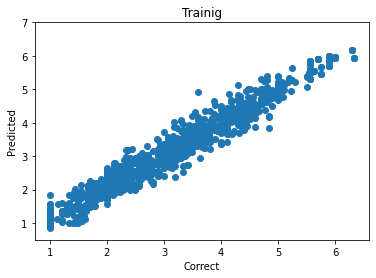

0.39754749451943766
{'rmse_mapped': 0.39222020122753454}


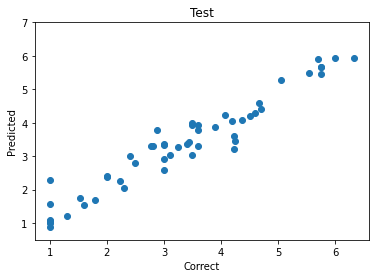

In [ ]:
from transformers import EvalPrediction
import numpy as np

labels_train = np.array(data_train.__get_labels__())
labels_test = np.array(data_test.__get_labels__())

y_pred_train = trainer.predict(test_dataset=data_train)[0]
y_pred_test = trainer.predict(test_dataset=data_test)[0]

print(metric_eval(labels_train, y_pred_train[0], classification=False))
print(rmse_mapped(EvalPrediction(predictions=y_pred_train, label_ids=labels_train)))
scatter_preds(labels_train, y_pred_train[0], 'Trainig')
print(metric_eval(labels_test, y_pred_test[0], classification=False))
print(rmse_mapped(EvalPrediction(predictions=y_pred_test, label_ids=labels_test)))
scatter_preds(labels_test, y_pred_test[0], 'Test')

In [ ]:
print(model.classifier.in_features)
torch.topk(model.classifier.weight, 5).indices

780


tensor([[569, 616, 724, 123, 586]], device='cuda:0')

In [ ]:
data_val_df = load_data_and_statistics(target_data_path)
#data_val_df = load_data_and_statistics(final_eval_path)
tok_encoded_val = tokenizer(list(data_val_df[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)

data_val = TextComplexityDataset(tok_encoded_val, data_val_df, numerical_cols, labels_col=None)

In [ ]:
data_val[0]['input_ids'].shape, data_train[0]['input_ids'].shape, data_test[0]['input_ids'].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


(torch.Size([99]), torch.Size([99]), torch.Size([99]))

In [ ]:
preds = trainer.predict(test_dataset=data_val)[0][0]
print(preds[preds < 1])
preds[preds < 1] = 1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


[]


In [ ]:
import pandas as pd
answer = pd.DataFrame()
answer['ID'] = data_val_df['ID']
answer['MOS'] = preds

#answer.to_csv('final_distilbert_statistics.csv', index=False)
answer.to_csv('answer.csv', index=False)

In [ ]:
trainer.save_model('/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_frozen_statistics_final')

## Modify train set

In [ ]:
import pandas as pd

In [ ]:
training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set.csv'
target_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/validation_set.csv'

In [ ]:
df = pd.read_csv(training_data_path)
df

,sentence_id,Sentence,MOS
0,3,"Etwa 5000 Jahre ist es her, seit die Sumerer d...",1.888889
1,4,Als Nebenprodukt entstand damals natürlich auc...,1.600000
2,5,"Wegen dieser leichten Vergänglichkeit wurde ,S...",4.428571
3,6,Dies spiegelt sich zum Beispiel in der Redewen...,3.300000
4,7,In der Kunst wird spätestens seit dem Barock d...,4.000000
...,...,...,...
995,1115,Sie können das Budget bekommen.,1.000000
996,1116,Wir beraten Sie gerne.,1.000000
997,1117,Wir beantworten Ihre Fragen.,1.000000
998,1118,Und wir helfen Ihnen beim Ausfüllen vom Antrag.,1.300000


In [ ]:
df_complex = df[df.MOS >5.5]
df_new = df.append([df_complex]*3).reset_index(drop=False)
df_new = df_new.sample(frac=1).reset_index(drop=True)

In [ ]:
df_new.to_csv('/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced.csv', index=False)